# Explore simulated relationship (part 2)

This notebook is using simulated data generated from [main_Pa_sim_enhance_AtoB](1_main_Pa_sim_enhance_AtoB.ipynb).  This notebook input raw Pseudomonas gene expression data from the Pseudomonas compendium referenced in [ADAGE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/) paper and added a strong nonlinear signal.  This signal assigned a set of genes to group A and a set of genes to group B.  If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

This notebook is extending from the exploration performed in [explore_relationship_AandB_pt1](explore_relationship_AandB_pt1.ipynb).  In this notebook we determined that the modeled/predicted gene expression data between A and B (i.e. after applying a linear transformation in the latent space and decoding) is a mostly linear relationship.  We assume that this means that the *decoder* is learning this linear relationship.  So now we want to determine what the *encoder* is learning. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import pickle
import seaborn as sns
from keras.models import model_from_json, load_model
from functions import utils
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Run notebook to generate simulated data
#%run ./main_Pa_sim_enhance_AtoB.ipynb

In [3]:
# Load 
base_dir = os.path.dirname(os.getcwd())
analysis_name = 'sim_balancedAB_100_2latent'

sim_data_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "train_model_input.txt.xz"
)

A_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetA.txt"
)

B_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetB.txt"
)

offset_vae_file = os.path.join(
    os.path.dirname(os.getcwd()), 
    "encoded",
    analysis_name, 
    "offset_latent_space_vae.txt"
)

weight_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    analysis_name,
    "VAE_weight_matrix.txt"
)

model_encoder_file = glob.glob(os.path.join(
    base_dir,
    "models",
    analysis_name,
    "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models",
        analysis_name,
        "*_encoder_weights.h5"
    )
)[0]

model_decoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models",
        analysis_name, 
        "*_decoder_model.h5"
    )
)[0]

weights_decoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models", 
        analysis_name, 
        "*_decoder_weights.h5"
    )
)[0]

In [4]:
# Output image files
positive_trend_file = os.path.join(
    base_dir,
    "viz",
    analysis_name,
    "input_A_B.png"
)
model_trend_file = os.path.join(
    base_dir,
    "viz",
    analysis_name,
    "model_A_transformB.png"
)

In [5]:
# Read data
sim_data = pd.read_table(sim_data_file, index_col=0, header=0, compression='xz')
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

print(sim_data.shape)
sim_data.head()

(1191, 200)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA2577,PA3764,PA5116,PA2218,PA2614,PA4125,PA4024,PA0425,PA2225,PA3735
0.1_12hr_CSV86(Pae_G1a).CEL,0.029353,0.029353,0.029353,0.029353,0.029353,0.029353,0.029353,0.029353,0.029353,0.029353,...,0.70029,0.247380,0.53853,0.50637,0.17964,0.28205,0.30069,0.10428,0.77525,0.29374
0.1_2hr_CSV86(Pae_G1a).CEL,0.345070,0.345070,0.345070,0.345070,0.345070,0.345070,0.345070,0.345070,0.345070,0.345070,...,0.43774,0.012674,0.42970,0.78015,0.23930,0.24961,0.12083,0.14876,0.63622,0.64786
0.1_6hr_CSV86(Pae_G1a).CEL,0.920990,0.920990,0.920990,0.920990,0.920990,0.920990,0.920990,0.920990,0.920990,0.920990,...,0.71728,0.655780,0.50908,1.00000,0.86554,0.64465,0.52303,0.53913,1.00000,0.81283
0.1_7hr_CSV86(Pae_G1a).CEL,0.676140,0.676140,0.676140,0.676140,0.676140,0.676140,0.676140,0.676140,0.676140,0.676140,...,0.27646,0.039524,0.50211,0.33054,1.00000,0.24673,0.34234,0.73899,0.68461,0.24690
0.1_9hr_CSV86(Pae_G1a).CEL,0.625600,0.625600,0.625600,0.625600,0.625600,0.625600,0.625600,0.625600,0.625600,0.625600,...,0.75593,0.687180,0.41966,0.88439,0.29710,0.63956,0.30400,0.20293,1.00000,0.50281


In [6]:
# Select samples that have expression of gene A around the threshold 
# Since threshold is 0.5 then select samples with expression in range(0.4, 0.6)

# Since our simulation set all genes in set A to be the same value for a give sample
# we can consider a single gene in set A to query by
rep_gene_A = geneSetA.iloc[0][0]

# Query for samples whose representative gene A expression is in range (0.4, 0.6)
#test_samples = sim_data.query('0.4 < @rep_gene_A < 0.6') -- why didn't this work?
test_samples = sim_data[(sim_data[rep_gene_A]>0.4) & (sim_data[rep_gene_A]<0.6)]

test_samples_sorted = test_samples.sort_values(by=[rep_gene_A])

print(test_samples_sorted.shape)
test_samples_sorted.head()

(220, 200)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA2577,PA3764,PA5116,PA2218,PA2614,PA4125,PA4024,PA0425,PA2225,PA3735
GSM560759.CEL,0.40011,0.40011,0.40011,0.40011,0.40011,0.40011,0.40011,0.40011,0.40011,0.40011,...,0.49561,0.57845,0.38028,0.40242,0.45133,0.31017,0.195860,0.55730,0.49532,0.46858
GSM1889281_D-Hyp_02.CEL,0.40110,0.40110,0.40110,0.40110,0.40110,0.40110,0.40110,0.40110,0.40110,0.40110,...,0.52001,0.58427,0.23895,0.35883,0.71689,0.19907,0.303910,0.59906,0.16866,0.84395
GSM1267092_HZI1955_Pae_G1a.CEL,0.40154,0.40154,0.40154,0.40154,0.40154,0.40154,0.40154,0.40154,0.40154,0.40154,...,0.39986,0.52264,0.18528,0.29214,0.72643,0.10379,0.294220,0.77104,0.37468,0.56339
GSM774135_B6-0_3.CEL,0.40225,0.40225,0.40225,0.40225,0.40225,0.40225,0.40225,0.40225,0.40225,0.40225,...,0.38674,0.72993,0.21025,0.19682,0.80207,0.12637,0.085574,0.70600,0.21338,0.81374
GSM2070517_OCio-07-MutS-1-d94-cipro-Pae_G1a-a1.CEL,0.40251,0.40251,0.40251,0.40251,0.40251,0.40251,0.40251,0.40251,0.40251,0.40251,...,0.37597,0.72180,0.18878,0.31634,0.90341,0.16841,0.402900,0.74420,0.24342,0.59430


## 1. Trend of gene B with respect to A (input)

How is B changing with respect to A in our simulated dataset (before the data goes into the autoencoder)?

Plot gene expression of A vs mean(gene B expression).  This plot will serve as a reference against later plots that will show the relationship between A and B after transforming the data (i.e. after the data has been fed through the autoencoder)

In [7]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = test_samples[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

20mM_CF600.CEL                 0.404801
2mM_KT2440.CEL                 0.571234
control1aerobic_Pae_G1a.CEL    0.544916
DB3.CEL                        0.610244
DC1.CEL                        0.591651
dtype: float64

In [8]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = test_samples[rep_gene_A]
original_B_mean_exp = geneSetB_mean

A_and_B_before_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      original_B_mean_exp.to_frame('mean gene B untransformed'),
                      left_index=True, right_index=True)
A_and_B_before_df.head()

,gene A untransformed,mean gene B untransformed
20mM_CF600.CEL,0.42429,0.404801
2mM_KT2440.CEL,0.51400,0.571234
control1aerobic_Pae_G1a.CEL,0.56985,0.544916
DB3.CEL,0.52760,0.610244
DC1.CEL,0.54947,0.591651


**Plot**
The plot below shows the signal that was added to the dataset.  This signal assigned a set of genes to group A and a set of genes to group B. If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

So we see a step function relationship between the expression of genes in group A and the expression of genes in group B.  With a threshold of 0.5 we can see that the expression of genes in B are upregulated.

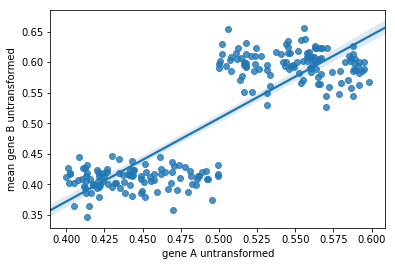

In [9]:
# Plot
positive_signal = sns.regplot(x='gene A untransformed',
            y='mean gene B untransformed',
           data = A_and_B_before_df)
fig = positive_signal.get_figure()
fig.savefig(positive_trend_file, dpi=300)

## 2.  Trend of gene B with respect to A (decoder)

How is B changing with respect to A after applying our latent space transformation?

Here we are only changing samples **after** they have been encoded into the latent space and we apply our latent space transformation.  Therefore, any trends that we observe we conclude that this relationship is what the decoder is learning.

In [10]:
# Define function to apply latent space transformation and output reconstructed data

def interpolate_in_vae_latent_space_AB(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Sort target gene data by expression (lowest --> highest)
    target_gene_sorted = target_gene_data.sort_values()

    lowest_file = os.path.join(encoded_dir, "lowest_encoded_vae.txt")
    low_exp_encoded = pd.read_table(lowest_file, header=0, index_col=0)
    
    # Average gene expression across samples in each extreme group
    lowest_mean_encoded = low_exp_encoded.mean(axis=0)

    # Format and rename as "baseline"
    baseline_encoded = pd.DataFrame(
        lowest_mean_encoded, index=offset_encoded.columns).T
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        intermediate_target_gene_exp = target_gene_sorted[sample_id]
        print('gene A exp is {}'.format(intermediate_target_gene_exp))
        alpha = get_scale_factor(
            target_gene_sorted, intermediate_target_gene_exp, percent_low, percent_high)
        print('scale factor is {}'.format(alpha))
        predict = baseline_encoded + alpha * offset_encoded

        predict_encoded_df = pd.DataFrame(predict)
        
        predicted_encoded_sample_data = (
            predicted_encoded_sample_data
            .append(predict_encoded_df, ignore_index=True)
        )
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict)
        
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        
        predicted_sample_data = (
            predicted_sample_data
            .append(predict_df, ignore_index=True)
        )

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')
    
def get_scale_factor(target_gene_sorted, expression_profile,
                     percent_low, percent_high):
    """
    get_scale_factor(target_gene_sorted: dataframe,
                    expression_profile: dataframe,
                    percent_low: integer,
                    percent_high: integer,):

    input:
        target_gene_sorted: dataframe of sorted target gene expression

        expression_profile: dataframe of gene expression for selected sample

        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1

    computation:
        Determine how much to scale offset based on distance along the target gene expression gradient

    Output:
     scale factor = intermediate gene expression/ (average high target gene expression - avgerage low target gene expression) 
    """

    # Collect the extreme gene expressions
    # Get sample IDs with the lowest 5% of reference gene expression
    threshold_low = np.percentile(target_gene_sorted, percent_low)
    lowest = target_gene_sorted[target_gene_sorted <= threshold_low]

    # Get sample IDs with the highest 5% of reference gene expression
    threshold_high = np.percentile(target_gene_sorted, percent_high)
    highest = target_gene_sorted[target_gene_sorted >= threshold_high]

    # Average gene expression across samples in each extreme group
    lowest_mean = (lowest.values).mean()
    highest_mean = (highest.values).mean()

    # Different in extremes
    denom = highest_mean - lowest_mean

    # scale_factor is the proportion along the gene expression gradient
    scale_factor = expression_profile / denom

    return scale_factor

In [11]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_AB(sim_data,
                                   test_samples_sorted,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


gene A exp is 0.40010999999999997
scale factor is 0.4202547385898622
gene A exp is 0.4011
scale factor is 0.42129458311062895
gene A exp is 0.40154
scale factor is 0.4217567362309697
gene A exp is 0.40225
scale factor is 0.4225024833115195
gene A exp is 0.40251
scale factor is 0.42277557379172087
gene A exp is 0.40501
scale factor is 0.42540144379365696
gene A exp is 0.40526
scale factor is 0.4256640307938506
gene A exp is 0.4078
scale factor is 0.42833191471581766
gene A exp is 0.40808
scale factor is 0.4286260121560345
gene A exp is 0.41013999999999995
scale factor is 0.43078972903762985
gene A exp is 0.41081999999999996
scale factor is 0.43150396567815646
gene A exp is 0.41145
scale factor is 0.4321656849186444
gene A exp is 0.41198
scale factor is 0.4327223693590549
gene A exp is 0.41225
scale factor is 0.43300596331926394
gene A exp is 0.41266
scale factor is 0.4334366059995815
gene A exp is 0.41272
scale factor is 0.4334996268796279
gene A exp is 0.41286999999999996
scale factor 

scale factor is 0.5904951425553838
gene A exp is 0.56266
scale factor is 0.5909888061157479
gene A exp is 0.56317
scale factor is 0.5915244835961427
gene A exp is 0.56329
scale factor is 0.5916505253562357
gene A exp is 0.5634600000000001
scale factor is 0.5918290845163675
gene A exp is 0.56352
scale factor is 0.5918921053964139
gene A exp is 0.56424
scale factor is 0.5926483559569714
gene A exp is 0.565
scale factor is 0.59344662043756
gene A exp is 0.56516
scale factor is 0.5936146761176839
gene A exp is 0.5653699999999999
scale factor is 0.5938352491978466
gene A exp is 0.5662
scale factor is 0.5947070380384895
gene A exp is 0.5665600000000001
scale factor is 0.5950851633187683
gene A exp is 0.56685
scale factor is 0.5953897642389927
gene A exp is 0.56707
scale factor is 0.5956208407991631
gene A exp is 0.56779
scale factor is 0.5963770913597207
gene A exp is 0.56985
scale factor is 0.5985408082413161
gene A exp is 0.57031
scale factor is 0.5990239683216724
gene A exp is 0.570789999

**Plot**
Plot transformed gene expression A vs mean transformed expression of genes in set B

Q: What is the relationship between genes in set A and B?  As the expression of A varies how does the expression of B vary?

In [12]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(220, 200)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA2577,PA3764,PA5116,PA2218,PA2614,PA4125,PA4024,PA0425,PA2225,PA3735
GSM560759.CEL,0.368880,0.371127,0.370123,0.369458,0.371333,0.369039,0.369083,0.368694,0.366213,0.371847,...,0.535573,0.666225,0.341222,0.359490,0.725123,0.225837,0.364043,0.709345,0.286249,0.670193
GSM1889281_D-Hyp_02.CEL,0.370925,0.373207,0.372214,0.371498,0.373393,0.371080,0.371131,0.370751,0.368275,0.373912,...,0.535963,0.666755,0.341484,0.359759,0.725703,0.226013,0.364389,0.709975,0.286432,0.670717
GSM1267092_HZI1955_Pae_G1a.CEL,0.371836,0.374133,0.373145,0.372406,0.374311,0.371989,0.372042,0.371666,0.369193,0.374832,...,0.536137,0.666991,0.341600,0.359879,0.725960,0.226091,0.364542,0.710255,0.286514,0.670949
GSM774135_B6-0_3.CEL,0.373307,0.375629,0.374649,0.373873,0.375793,0.373457,0.373514,0.373146,0.370676,0.376317,...,0.536417,0.667371,0.341788,0.360072,0.726374,0.226217,0.364791,0.710707,0.286645,0.671324
GSM2070517_OCio-07-MutS-1-d94-cipro-Pae_G1a-a1.CEL,0.373846,0.376177,0.375201,0.374411,0.376336,0.373995,0.374054,0.373688,0.371220,0.376861,...,0.536519,0.667510,0.341856,0.360142,0.726526,0.226264,0.364882,0.710872,0.286693,0.671461


In [13]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

GSM560759.CEL                                         0.485413
GSM1889281_D-Hyp_02.CEL                               0.485781
GSM1267092_HZI1955_Pae_G1a.CEL                        0.485945
GSM774135_B6-0_3.CEL                                  0.486209
GSM2070517_OCio-07-MutS-1-d94-cipro-Pae_G1a-a1.CEL    0.486306
dtype: float64

In [14]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_exp = predict_gene_exp[rep_gene_A]
predict_B_mean_exp = geneSetB_mean

A_and_B_predict_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_predict_df.head()

,gene A untransformed,mean gene B transformed
20mM_CF600.CEL,0.42429,0.494370
2mM_KT2440.CEL,0.51400,0.526573
control1aerobic_Pae_G1a.CEL,0.56985,0.545792
DB3.CEL,0.52760,0.531309
DC1.CEL,0.54947,0.538849


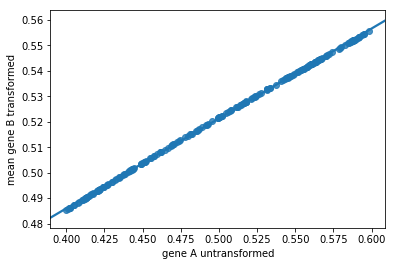

In [15]:
# Plot
sns.regplot(x='gene A untransformed',
            y='mean gene B transformed',
           data = A_and_B_predict_df)

## 3.  Trend of gene B with respect to A (encoder)

How is B changing with respect to A after shifting input expression and then applying our latent space transformation?

Here we are only changing samples **before** they have been encoded into the latent space and then we apply our latent space transformation.  If we compare these trends with those from #2 module, which show what the decoder is supposedly learning, then we can conclude what the encoder is learning.

In order to test this we manually shift A genes from being below the activation threshold to being above it and see how the gene expression data is reconstructed

In [16]:
# Artificially shift gene A expression

# Get single sample
test_sample = test_samples_sorted.index[0]
print(test_sample)

# Sample with original value of gene A
A_exp_sample = test_samples_sorted.loc[test_sample]

A_exp_sample_modified_df = pd.DataFrame()

A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

# Artificially shift genes in set A
new_A_exp = np.linspace(0.41, 0.60, num=100)

for i in new_A_exp:
    test_samples_sorted.loc[test_sample,geneSetA_ls] = i
    A_exp_sample = test_samples_sorted.loc[test_sample]
    A_exp_sample_modified_df = A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

A_exp_sample_modified_df.head()

GSM560759.CEL


,PA0027,PA0028,PA0029,PA0055,PA0077,PA0084,PA0096,PA0106,PA0114,PA0193,...,PA5207,PA5263,PA5274,PA5319,PA5367,PA5393,PA5460,PA5508,PA5509,PA5552
0,0.52765,0.36517,0.410000,0.410000,0.410000,0.410000,0.410000,0.410000,0.410000,0.410000,...,0.27926,0.48516,0.42271,0.38316,0.410000,0.41688,0.410000,0.410000,0.42408,0.62752
1,0.52765,0.36517,0.411919,0.411919,0.411919,0.411919,0.411919,0.411919,0.411919,0.411919,...,0.27926,0.48516,0.42271,0.38316,0.411919,0.41688,0.411919,0.411919,0.42408,0.62752
2,0.52765,0.36517,0.413838,0.413838,0.413838,0.413838,0.413838,0.413838,0.413838,0.413838,...,0.27926,0.48516,0.42271,0.38316,0.413838,0.41688,0.413838,0.413838,0.42408,0.62752
3,0.52765,0.36517,0.415758,0.415758,0.415758,0.415758,0.415758,0.415758,0.415758,0.415758,...,0.27926,0.48516,0.42271,0.38316,0.415758,0.41688,0.415758,0.415758,0.42408,0.62752
4,0.52765,0.36517,0.417677,0.417677,0.417677,0.417677,0.417677,0.417677,0.417677,0.417677,...,0.27926,0.48516,0.42271,0.38316,0.417677,0.41688,0.417677,0.417677,0.42408,0.62752


In [17]:
# Define function to apply latent space transformation to SHIFTED data and output reconstructed data

def interpolate_in_vae_latent_space_shiftA(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "shifted_predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "shifted_predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        sample_exp = sample_data.loc[sample_id].to_frame().T
        
        # Use trained model to encode expression data into SAME latent space
        predict = loaded_model.predict_on_batch(sample_exp)

        predict_encoded_df = pd.DataFrame(predict)
        
        predicted_encoded_sample_data = (
            predicted_encoded_sample_data
            .append(predict_encoded_df, ignore_index=True)
        )
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict_encoded_df)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        
        predicted_sample_data = (
            predicted_sample_data
            .append(predict_df, ignore_index=True)
        )

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')

In [18]:
# Define function to apply latent space transformation to SHIFTED data and output reconstructed data

def interpolate_in_pca_latent_space_shiftA(all_data, 
                                       sample_data,
                                       model_dir,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_pca_latent_space(data_dir: string,
                                    model_dir: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    out_dir: string,
                                    percent_low: integer,
                                    percent_high: integer):

    input:
        data_dir: directory containing the raw gene expression data and the offset vector

        model_dir: directory containing the learned vae models

        encoded_dir: directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below

        out_dir: directory to output predicted gene expression to

        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Samples are encoded into PCA latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. predicted expression profile per sample (intermediate samples x 2 statistical scores --> correlation and pvalue)
         2. target gene expression sorted by expression level for reference when plotting
    """

    # Load arguments
    #offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")
    model_file = os.path.join(model_dir, "pca_model.pkl")

    # Output file
    predict_file = os.path.join(out_dir, "shifted_predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "shifted_predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    #offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # load pca model
    infile = open(model_file, 'rb')
    pca = pickle.load(infile)
    infile.close()
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        sample_exp = sample_data.loc[sample_id].to_frame().T
        
        # Use trained model to encode expression data into SAME latent space
        predict = pca.transform(sample_exp)

        predict_encoded_df = pd.DataFrame(predict)
        
        predicted_encoded_sample_data = (
            predicted_encoded_sample_data
            .append(predict_encoded_df, ignore_index=True)
        )
        
        # Decode prediction
        predict_decoded = pca.inverse_transform(predict_encoded_df)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        
        predicted_sample_data = (
            predicted_sample_data
            .append(predict_df, ignore_index=True)
        )

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')

In [19]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)
model_dir = os.path.join(base_dir, "models", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_shiftA(sim_data,
                                   A_exp_sample_modified_df,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

#interpolate_in_pca_latent_space_shiftA(sim_data,
#                                   A_exp_sample_modified_df,
#                                   model_dir,
#                                   encoded_dir,
#                                   rep_gene_A,
#                                   percent_low,
#                                   percent_high,
#                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "shifted_predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(100, 200)


,PA0027,PA0028,PA0029,PA0055,PA0077,PA0084,PA0096,PA0106,PA0114,PA0193,...,PA5207,PA5263,PA5274,PA5319,PA5367,PA5393,PA5460,PA5508,PA5509,PA5552
0,0.444693,0.439237,0.438089,0.442226,0.441719,0.443067,0.445495,0.441936,0.435777,0.437898,...,0.526888,0.655180,0.350877,0.360753,0.705626,0.233370,0.367299,0.685330,0.300181,0.651016
1,0.445761,0.440400,0.439208,0.443306,0.442763,0.444103,0.446624,0.443100,0.436898,0.438969,...,0.527284,0.655847,0.351058,0.360961,0.706287,0.233486,0.367458,0.686034,0.300358,0.651529
2,0.446828,0.441565,0.440328,0.444386,0.443807,0.445139,0.447754,0.444265,0.438020,0.440041,...,0.527679,0.656513,0.351238,0.361170,0.706948,0.233602,0.367618,0.686737,0.300536,0.652041
3,0.447897,0.442730,0.441448,0.445467,0.444852,0.446176,0.448884,0.445431,0.439142,0.441113,...,0.528075,0.657179,0.351419,0.361378,0.707608,0.233719,0.367777,0.687439,0.300713,0.652553
4,0.448966,0.443895,0.442569,0.446549,0.445897,0.447213,0.450015,0.446597,0.440265,0.442185,...,0.528470,0.657845,0.351599,0.361587,0.708267,0.233835,0.367936,0.688140,0.300891,0.653065


In [21]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_transformed_mean = geneSetB_exp.mean(axis=1)
geneSetB_transformed_mean.head()

0    0.449443
1    0.450162
2    0.450882
3    0.451601
4    0.452321
dtype: float64

**Plot:** Original A vs Transformed A

In [22]:
# Join original expression of A and transformed expression of A
original_A_exp = A_exp_sample_modified_df[rep_gene_A]
predict_A_exp = predict_gene_exp[rep_gene_A]

original_A_vs_transformed_A_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_A_exp.to_frame('gene A transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_A_df.head()

,gene A untransformed,gene A transformed
0,0.410000,0.375574
1,0.411919,0.375695
2,0.413838,0.375816
3,0.415758,0.375937
4,0.417677,0.376058


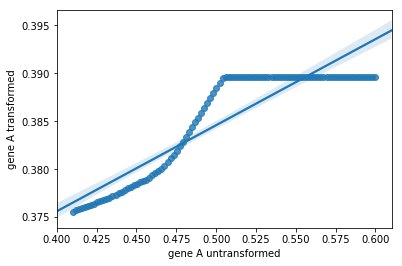

In [23]:
# Plot
sns.regplot(x='gene A untransformed',
            y='gene A transformed',
           data = original_A_vs_transformed_A_df)

**Plot:** Original A vs Mean(Transformed B)

In [24]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = A_exp_sample_modified_df[rep_gene_A]
predict_B_mean_exp = geneSetB_transformed_mean

original_A_vs_transformed_B_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_B_df.head()

,gene A untransformed,mean gene B transformed
0,0.410000,0.449443
1,0.411919,0.450162
2,0.413838,0.450882
3,0.415758,0.451601
4,0.417677,0.452321


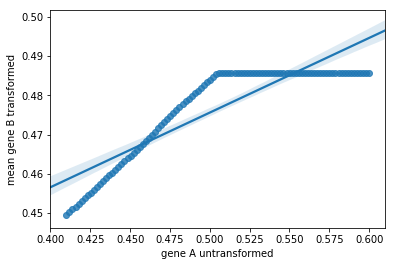

In [25]:
# Plot
# A before transformation vs B after transformation
A_transformB = sns.regplot(x='gene A untransformed',
            y='mean gene B transformed',
           data = original_A_vs_transformed_B_df)
fig = A_transformB.get_figure()
fig.savefig(model_trend_file, dpi=300)

**Plot:** Transformed A vs Mean(Transformed B)

In [26]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_exp = predict_gene_exp[rep_gene_A]
predict_B_mean_exp = geneSetB_transformed_mean

A_and_B_predict_df = pd.merge(predict_A_exp.to_frame('gene A transformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_predict_df.head()

,gene A transformed,mean gene B transformed
0,0.375574,0.449443
1,0.375695,0.450162
2,0.375816,0.450882
3,0.375937,0.451601
4,0.376058,0.452321


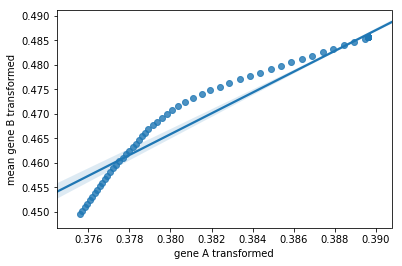

In [27]:
# Plot
sns.regplot(x='gene A transformed',
            y='mean gene B transformed',
           data = A_and_B_predict_df)

## 4.  Trend of gene B with respect to A (encoder)

We will perform the same analysis as before but this time we will manually shift B genes from being below the activation threshold to being above it and see how the gene expression data is reconstructed

In [28]:
# Artificially shift gene B expression

# Get single sample
test_sample = test_samples_sorted.index[0]
print(test_sample)

# Sample with original value of gene A
A_exp_sample = test_samples_sorted.loc[test_sample]

A_exp_sample_modified_df = pd.DataFrame()

A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

# Artificially shift genes in set A
new_A_exp = np.linspace(0.41, 0.60, num=100)

for i in new_A_exp:
    test_samples_sorted.loc[test_sample,geneSetA_ls] = i
    A_exp_sample = test_samples_sorted.loc[test_sample]
    A_exp_sample_modified_df = A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

A_exp_sample_modified_df.head()

GSM560759.CEL


,PA0027,PA0028,PA0029,PA0055,PA0077,PA0084,PA0096,PA0106,PA0114,PA0193,...,PA5207,PA5263,PA5274,PA5319,PA5367,PA5393,PA5460,PA5508,PA5509,PA5552
0,0.52765,0.36517,0.410000,0.410000,0.410000,0.410000,0.410000,0.410000,0.410000,0.410000,...,0.27926,0.48516,0.42271,0.38316,0.410000,0.41688,0.410000,0.410000,0.42408,0.62752
1,0.52765,0.36517,0.411919,0.411919,0.411919,0.411919,0.411919,0.411919,0.411919,0.411919,...,0.27926,0.48516,0.42271,0.38316,0.411919,0.41688,0.411919,0.411919,0.42408,0.62752
2,0.52765,0.36517,0.413838,0.413838,0.413838,0.413838,0.413838,0.413838,0.413838,0.413838,...,0.27926,0.48516,0.42271,0.38316,0.413838,0.41688,0.413838,0.413838,0.42408,0.62752
3,0.52765,0.36517,0.415758,0.415758,0.415758,0.415758,0.415758,0.415758,0.415758,0.415758,...,0.27926,0.48516,0.42271,0.38316,0.415758,0.41688,0.415758,0.415758,0.42408,0.62752
4,0.52765,0.36517,0.417677,0.417677,0.417677,0.417677,0.417677,0.417677,0.417677,0.417677,...,0.27926,0.48516,0.42271,0.38316,0.417677,0.41688,0.417677,0.417677,0.42408,0.62752


**Plot:** Mean(Untransformed B) vs Mean(Transformed B)

In [29]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = A_exp_sample_modified_df[geneSetB_ls]

# Get the mean for each sample
geneSetB_original_mean = geneSetB_exp.mean(axis=1)
geneSetB_original_mean.head()

0    0.412201
1    0.412201
2    0.412201
3    0.412201
4    0.412201
dtype: float64

In [30]:
# Join original expression of transformed A and mean(transformed expression of B)
original_B_exp = geneSetB_original_mean
predict_B_mean_exp = geneSetB_transformed_mean

original_B_vs_transformed_B_df = pd.merge(original_B_exp.to_frame('mean gene B untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
original_B_vs_transformed_B_df.head()

,mean gene B untransformed,mean gene B transformed
0,0.412201,0.449443
1,0.412201,0.450162
2,0.412201,0.450882
3,0.412201,0.451601
4,0.412201,0.452321


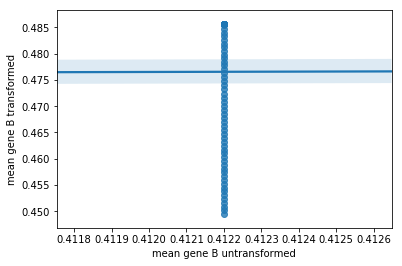

In [31]:
# Plot
sns.regplot(x='mean gene B untransformed',
            y='mean gene B transformed',
           data = original_B_vs_transformed_B_df)